In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm  #  tqdm is a Python library for adding progress bar

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BASE_DIR = '/kaggle/input/anime-faces/data/'

In [3]:
# load complete image paths to the list
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

In [4]:
# remove unnecessary file
image_paths.remove('/kaggle/input/anime-faces/data/data')

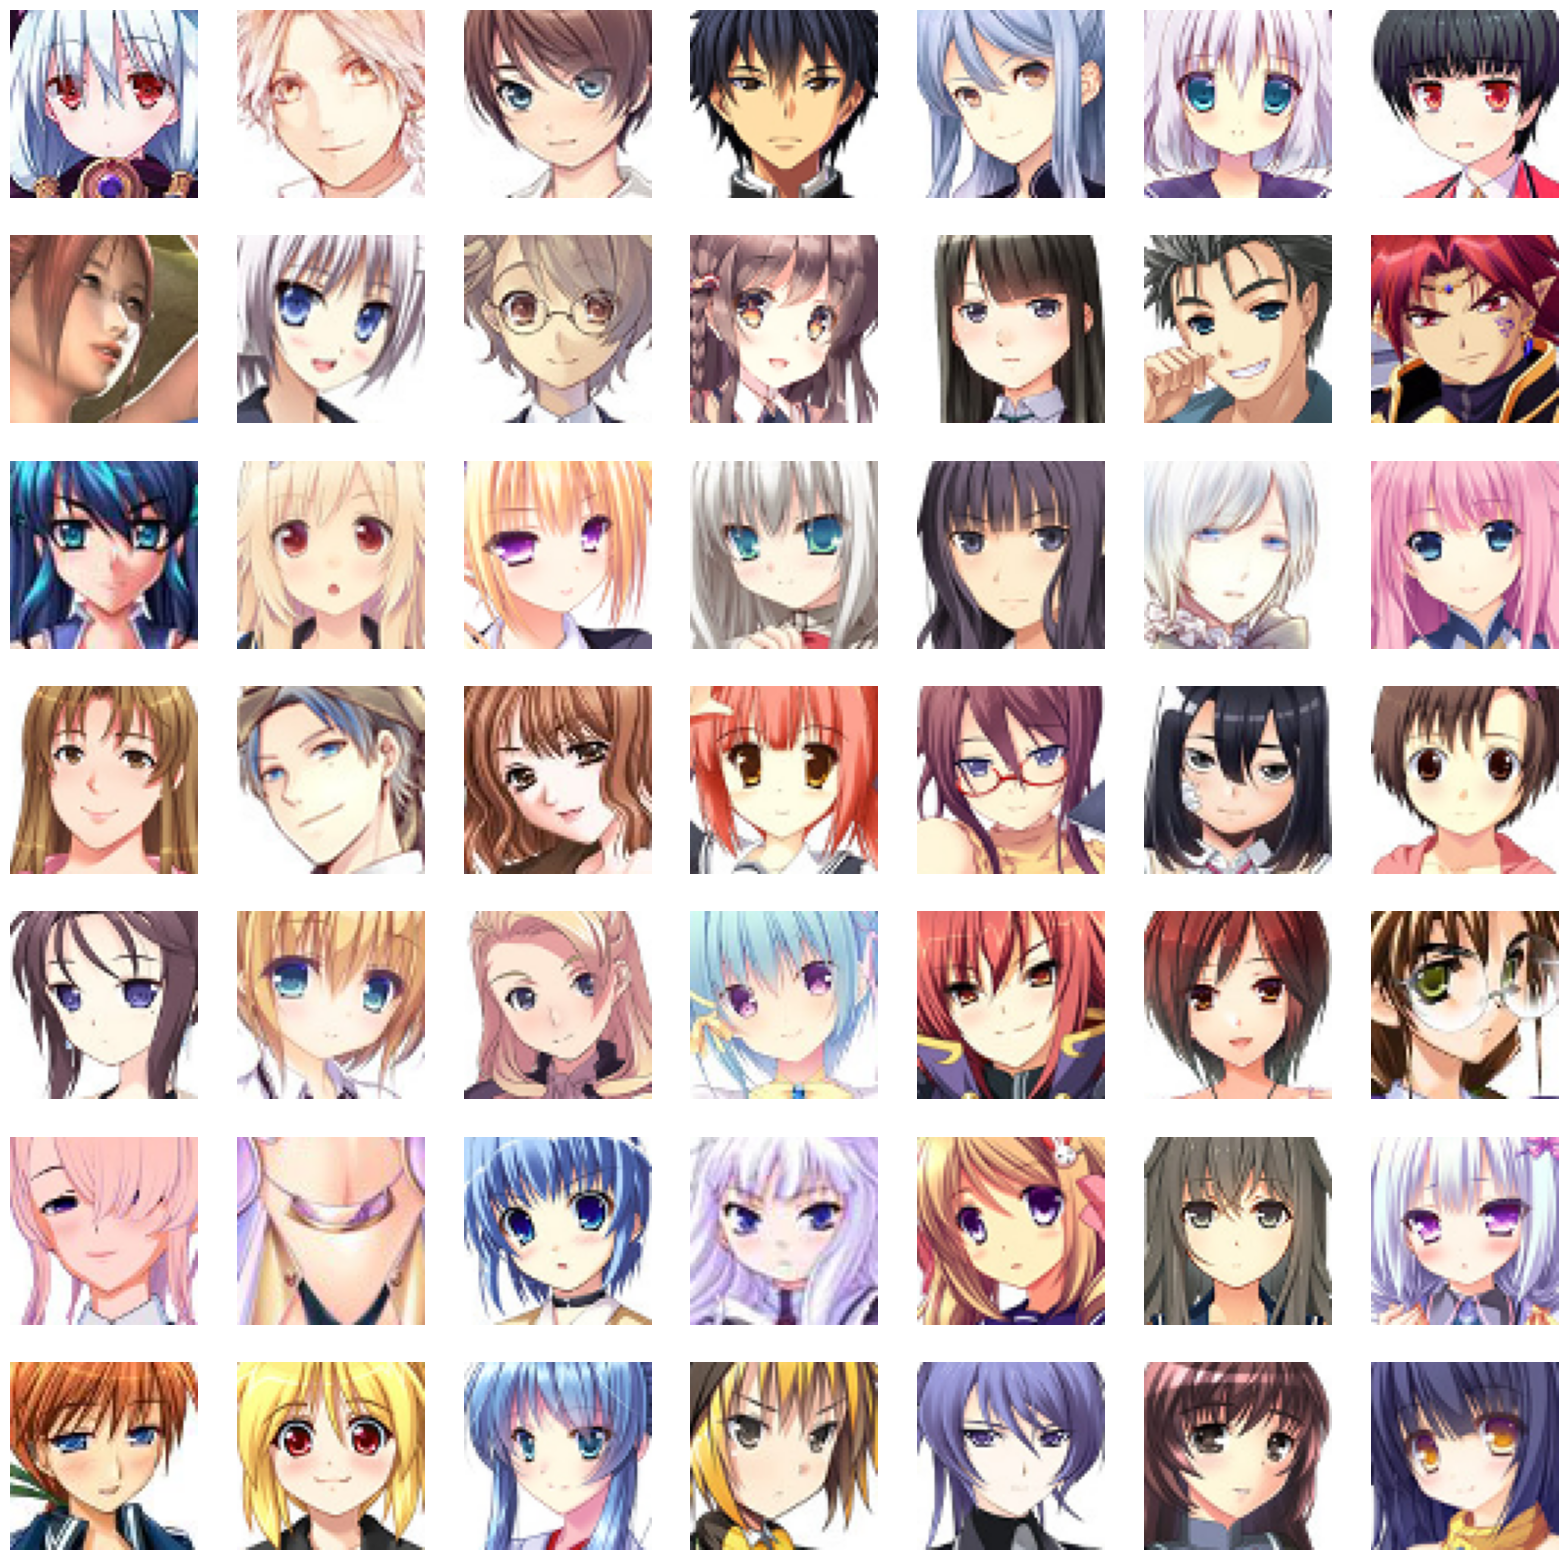

In [5]:
# Next we will visualize few images in the dataset

# to display grid of images (7x7)
plt.figure(figsize=(20, 20))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)
    # load the image
    img = load_img(image_path)
    # convert to numpy array
    img = np.array(img)
    # show the image
    plt.imshow(img)
    plt.axis('off')
    # increment the index for next image
    index += 1

In [6]:
# Next we will preprocess the dataset

# load the image and convert to numpy array
train_images = [np.array(load_img(path)) for path in tqdm(image_paths)]
train_images = np.array(train_images)

  0%|          | 0/21551 [00:00<?, ?it/s]

In [7]:
train_images[0].shape

(64, 64, 3)

In [8]:
# Next we will reshape the numpy array

# reshape the array
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')

In [9]:
# normalize the images
train_images = (train_images - 127.5) / 127.5

In [10]:
train_images[0]

array([[[-0.7254902 , -0.90588236, -0.7176471 ],
        [-0.70980394, -0.88235295, -0.6862745 ],
        [-0.7019608 , -1.        , -0.7176471 ],
        ...,
        [-0.09019608,  0.01176471,  0.3882353 ],
        [-0.19215687,  0.05882353,  0.4509804 ],
        [-0.34117648, -0.13725491,  0.29411766]],

       [[-0.7254902 , -0.90588236, -0.7176471 ],
        [-0.73333335, -0.8666667 , -0.7019608 ],
        [-0.52156866, -0.8666667 , -0.5686275 ],
        ...,
        [-0.29411766,  0.01176471,  0.3019608 ],
        [-0.08235294,  0.15294118,  0.5294118 ],
        [-0.23921569,  0.09019608,  0.45882353]],

       [[-0.7019608 , -0.8901961 , -0.7019608 ],
        [-0.7176471 , -0.8745098 , -0.69411767],
        [-0.5686275 , -0.8509804 , -0.58431375],
        ...,
        [-0.22352941,  0.1764706 ,  0.48235294],
        [-0.13725491,  0.1764706 ,  0.4745098 ],
        [-0.06666667,  0.24705882,  0.5058824 ]],

       ...,

       [[-0.30980393, -0.6862745 , -0.29411766],
        [-0

In [11]:
#First we will initialize the required values to the variables

# Latent Space is an abstract, lower-dimensional representation of high-dimensional data,
# often used in machine learning and data science to simplify complex data structures 
# and reveal hidden patterns.

# latent dimension for random noise


LATENT_DIM = 100
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# no. of channels of the image
CHANNELS = 3 # for gray scale, keep it as 1

In [12]:
# Generator Model will create new images similar to training data from random noise

model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

In [13]:
# Discriminator model will classify the image from the generator to check whether it real (or) fake images

model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

In [14]:
# Create DCGAN

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [15]:
# Next we will plot some images for each epoch

class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()
        
    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [16]:
# Now let us initialize the DCGAN model 

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [17]:
# Next let us compile the DCGAN model

D_LR = 0.0001 
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [ ]:
# Next we will train the model

N_EPOCHS = 50
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

In [ ]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
# generate the image from noise
g_img = dcgan.generator(noise)
# denormalize the image
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
plt.show()